# Asthma and Smoke Estimate Analysis

In this Notebook, we will explore the following questions for Green Bay, Wisconsin:

- What is the relationship between asthma metrics (emergency visits, hospitalizations) and smoke estimates?
- What does this mean for the people of Green Bay, Wisconsin?

We build off the smoke estimate created in the `common_analysis.ipynb` Notebook and bring in asthma data for Brown County, WI from the [Environmental Public Health Tracking: Asthma Data dashboard](https://www.dhs.wisconsin.gov/epht/asthma.htm) provided by the Wisconsin Department of Health Services. As outlined in the [Wisconsin.Gov Privacy Policy](https://www.wisconsin.gov/Pages/Policies.aspx), material on the website is available for noncommercial use by the general public under fair use guidelines. The data itself follows HIPAA guidelines by retaining the data anonymously. Counts less than five but more than zero are suppressed to protect confidentiality.

This notebook is available under the MIT license.

Start by importing necessary Python modules.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

## Data
### Asthma Data
The following datasets are from the [Environmental Public Health Tracking: Asthma Data dashboard](https://www.dhs.wisconsin.gov/epht/asthma.htm).

### Metric Definitions
We use age-adjusted rates of asthma-related hospitalizations and emergency room visits per 10,000 people in Brown County, Wisconsin from the year 2000 through 2023. The dataset also includes the overall age-adjusted rates of asthma-related hospitalizations and emergency room visits in the state of Wisconsin for each year to facilitate comparisons between Brown County and the State.

Note that emergency department visits include those that result in hospitalization, meaning that there will be some overlap between counts in the emergency visit and hospitalization datasets.

Age-adjusted rates are used instead of raw counts and crude rates to facilitate comparisons and account for the possibility that emergency department visits and hospitalizations for asthma may be more frequent among different age groups. The denominator for the rates comes from the population of interest – for example, the rate for Brown County looks at the Brown County population only, while the overall Wisconsin rates will take all Wisconsin residents into account. Age-adjustment is calculated using the 2000 U.S. standard population published by the National Center for Health Statistics (NCHS) using projections from the U.S. Census. 

### Data Cleaning
The datasets were first cleaned in Excel to retain just the county and state age-adjusted rates for each year by simply removing the unncessary columns. We will then need to transpose and clean the data further before we can use it in our analyses.

In [20]:
# load emergency visits data
emergency_visits_csv = pd.read_csv("asthma_data/Brown County Asthma Emergency Visit Rates.csv")
emergency_visits_csv.head()

,Year,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,County rate,43.40,46.60,46.20,39.90,44.10,39.80,39.00,43.90,42.20,...,39.10,38.50,40.70,37.20,36.10,33.00,22.70,22.90,28.00,24.3
1,State rate,48.21,50.27,46.32,47.23,43.99,44.32,44.43,46.01,40.75,...,39.49,43.64,38.44,38.01,36.67,35.42,22.87,27.32,28.47,30.9
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# remove nulls
emergency_visits_csv.dropna(inplace=True)
# melt the data
emergency_visits_melt = pd.melt(emergency_visits_csv, id_vars=['Year'], value_name='Emergency Rate').copy()
emergency_visits_melt = emergency_visits_melt.rename(columns={'Year': 'Rate Type', 'variable': 'Year'})
emergency_visits_melt = emergency_visits_melt[['Year', 'Rate Type', 'Emergency Rate']]
# filter to just country rates
emergency_visits = emergency_visits_melt[emergency_visits_melt['Rate Type'] == 'County rate'].copy()
emergency_visits.reset_index(drop=True)

,Year,Rate Type,Emergency Rate
0,2002,County rate,43.4
1,2003,County rate,46.6
2,2004,County rate,46.2
3,2005,County rate,39.9
4,2006,County rate,44.1
5,2007,County rate,39.8
6,2008,County rate,39.0
7,2009,County rate,43.9
8,2010,County rate,42.2
9,2011,County rate,41.4


In [ ]:
# load hospitalizations data
hospitalizations_csv = pd.read_csv("asthma_data/Brown County Asthma Hospitalization Rates.csv")
hospitalizations_csv.head()

,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,County rate,9.10,8.80,8.80,10.50,8.40,7.30,8.50,7.40,6.5,...,5.1,4.40,3.40,3.10,3.10,3.50,3.30,1.40,1.90,3.00
1,State rate,10.72,10.23,9.73,11.26,9.82,10.17,9.13,8.88,9.4,...,8.4,8.73,6.64,3.51,3.58,3.59,2.97,1.62,2.13,2.43
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# remove nulls
hospitalizations_csv.dropna(inplace=True)
# melt the data
hospitalizations_melt = pd.melt(hospitalizations_csv, id_vars=['Year'], value_name='Hospitalization Rate').copy()
hospitalizations_melt = hospitalizations_melt.rename(columns={'Year': 'Rate Type', 'variable': 'Year'})
hospitalizations_melt = hospitalizations_melt[['Year', 'Rate Type', 'Hospitalization Rate']]
# filter to just country rates
hospitalizations = hospitalizations_melt[hospitalizations_melt['Rate Type'] == 'County rate'].copy()
hospitalizations.reset_index(drop=True)

,Year,Rate Type,Hospitalization Rate
0,2000,County rate,9.1
1,2001,County rate,8.8
2,2002,County rate,8.8
3,2003,County rate,10.5
4,2004,County rate,8.4
5,2005,County rate,7.3
6,2006,County rate,8.5
7,2007,County rate,7.4
8,2008,County rate,6.5
9,2009,County rate,7.8


### Smoke Estimate Data
Here we import the smoke estimates and predictions from the intermediate csv files created in the `common_analysis.ipynb` Notebook. We will use these later to perform analyses with the asthma data.

In [30]:
# import smoke estimates
smoke_estimates = pd.read_csv('intermediate_data/smoke_estimates.csv')
# remove the redundant index column
smoke_estimates = smoke_estimates[['Fire_Year', 'Agg_Smoke_Estimate', 'Smoke_Estimate']]
smoke_estimates.head()

,Fire_Year,Agg_Smoke_Estimate,Smoke_Estimate
0,1964,3.767711,0.020477
1,1965,70.480446,0.383046
2,1966,0.811870,0.004412
3,1967,20.258481,0.110100
4,1968,1.740473,0.009459


In [32]:
# import smoke estimate predictions from 2025-2050
smoke_predictions = pd.read_csv('intermediate_data/smoke_predictions.csv')
# remove the redundant index column
smoke_predictions = smoke_predictions[['Year', 'Forecast', 'Upper CI', 'Lower CI']]
smoke_predictions.head()

,Year,Forecast,Upper CI,Lower CI
0,2025,27.956011,45.155746,10.991589
1,2026,27.845015,46.242911,10.212320
2,2027,29.054728,46.273956,11.016964
3,2028,29.850270,48.546989,10.905273
4,2029,29.749102,51.049339,10.630108


## Exploratory Analysis

In this section we explore the asthma-related metrics for Brown County, WI. We start by looking at each metric's trend over time, and then compare the two metrics.

<Figure size 1000x600 with 0 Axes>

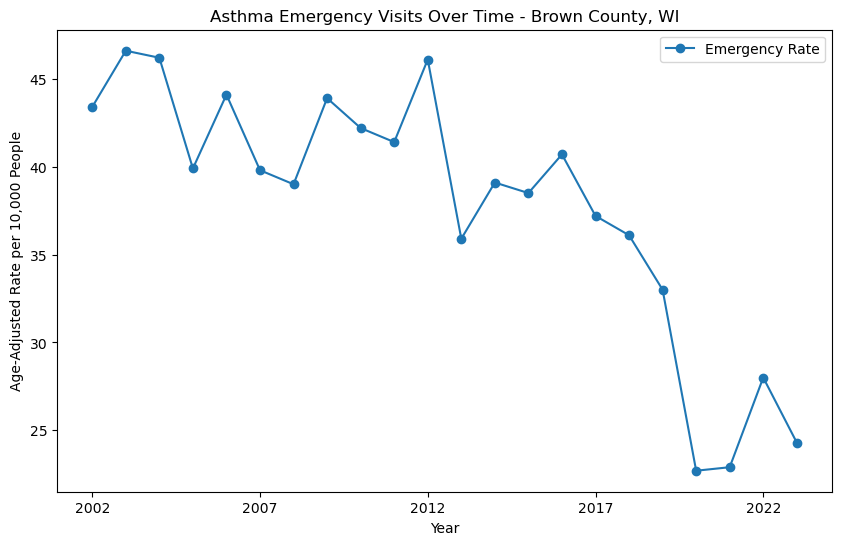

In [ ]:
# plot emergency visits over time
plt.figure(figsize=(10, 6))
emergency_visits.plot(x='Year', y='Emergency Rate', kind='line', marker='o',
                      title='Asthma Emergency Visits Over Time - Brown County, WI', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.show()

<Figure size 1000x600 with 0 Axes>

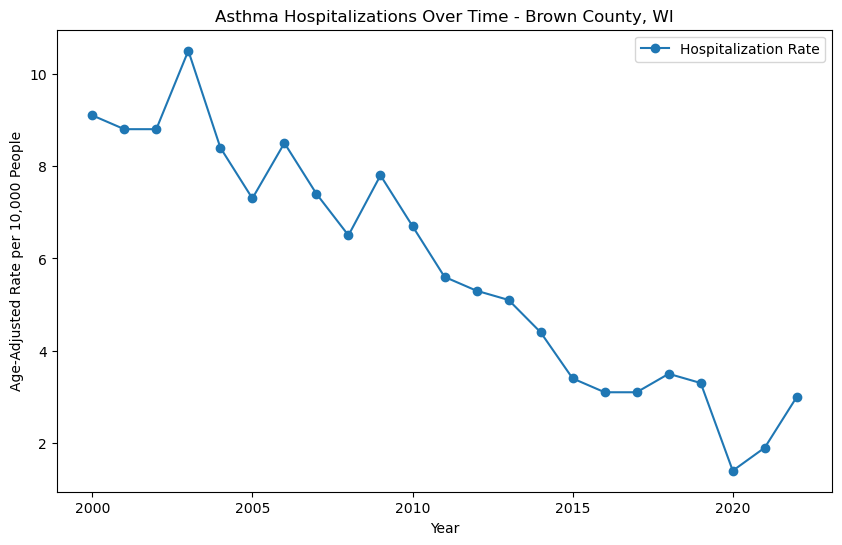

In [34]:
# plot hospitalizations over time
plt.figure(figsize=(10, 6))
hospitalizations.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o',
                      title='Asthma Hospitalizations Over Time - Brown County, WI', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.show()

In [ ]:
# plot hospitalizations and emergency visits on one graph